# Background

This project will explore a anonymous data set. While the meaning of each column is not known, a simple K Nearest Neighbors algorithm will be applied to quickly train the model that can classify the target variables.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data exploration

In [2]:
df = pd.read_csv('Data/KNN_Project_Data')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
XVPM            1000 non-null float64
GWYH            1000 non-null float64
TRAT            1000 non-null float64
TLLZ            1000 non-null float64
IGGA            1000 non-null float64
HYKR            1000 non-null float64
EDFS            1000 non-null float64
GUUB            1000 non-null float64
MGJM            1000 non-null float64
JHZC            1000 non-null float64
TARGET CLASS    1000 non-null int64
dtypes: float64(10), int64(1)
memory usage: 86.1 KB


In [4]:
df.isnull().any()

XVPM            False
GWYH            False
TRAT            False
TLLZ            False
IGGA            False
HYKR            False
EDFS            False
GUUB            False
MGJM            False
JHZC            False
TARGET CLASS    False
dtype: bool

In [5]:
df.head()

,XVPM,GWYH,TRAT,TLLZ,IGGA,HYKR,EDFS,GUUB,MGJM,JHZC,TARGET CLASS
0,1636.670614,817.988525,2565.995189,358.347163,550.417491,1618.870897,2147.641254,330.727893,1494.878631,845.136088,0
1,1013.402760,577.587332,2644.141273,280.428203,1161.873391,2084.107872,853.404981,447.157619,1193.032521,861.081809,1
2,1300.035501,820.518697,2025.854469,525.562292,922.206261,2552.355407,818.676686,845.491492,1968.367513,1647.186291,1
3,1059.347542,1066.866418,612.000041,480.827789,419.467495,685.666983,852.867810,341.664784,1154.391368,1450.935357,0
4,1018.340526,1313.679056,950.622661,724.742174,843.065903,1370.554164,905.469453,658.118202,539.459350,1899.850792,0


All data is numeric and contains no missing values.

# Train and Test split

In [13]:
from sklearn.model_selection import train_test_split
X = df.drop('TARGET CLASS',axis=1)
y = df['TARGET CLASS']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)

# Preprocessing: standarization

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model training: KNN

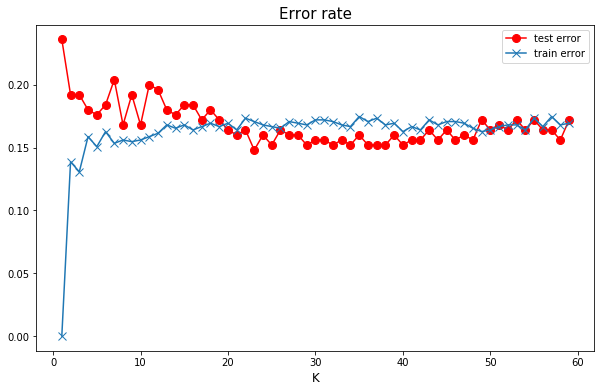

In [16]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []
error_rate_train = []

for i in range(1,60):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled,y_train)
    pred_i = knn.predict(X_test_scaled)
    error_rate.append(np.mean(pred_i != y_test))
    
    knn_train = KNeighborsClassifier(n_neighbors=i)
    knn_train.fit(X_train_scaled,y_train)
    knn_train_pred_i = knn_train.predict(X_train_scaled)
    error_rate_train.append(np.mean(knn_train_pred_i != y_train))

    
plt.figure(figsize=(10,6))
plt.plot(list(range(1,60)),error_rate,marker='o',markersize=8,label='test error',c='red')
plt.plot(list(range(1,60)),error_rate_train,marker='x',markersize=8,label='train error')
plt.xlabel('K',fontsize=12)
plt.title('Error rate',fontsize=15)
plt.legend()
plt.show()

In [231]:
print('Best n_neig: {}'.format(np.argmin(error_rate)+1))
print('Minimum loss attained: {:.4f}'.format(np.min(error_rate)))


Best n_neig: 23
Minimum loss attained: 0.1480


## KNN model with K = 23

In [17]:
knn = KNeighborsClassifier(n_neighbors=23).fit(X_train_scaled,y_train)

# Predictions and Evaluations

In [18]:
from sklearn.metrics import classification_report,confusion_matrix
y_predict = knn.predict(X_test_scaled)

In [19]:
pd.DataFrame(confusion_matrix(y_test,y_predict),index=['True 0','True 1'],
             columns=['Predicted 0','Predicted 1'])

,Predicted 0,Predicted 1
True 0,110,26
True 1,11,103


In [20]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86       136
           1       0.80      0.90      0.85       114

    accuracy                           0.85       250
   macro avg       0.85      0.86      0.85       250
weighted avg       0.86      0.85      0.85       250



## KNN model with K = 1 (for comparison)

In [21]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train_scaled,y_train)
y_predict = knn.predict(X_test_scaled)
pd.DataFrame(confusion_matrix(y_test,y_predict),index=['True 0','True 1'],
             columns=['Predicted 0','Predicted 1'])

,Predicted 0,Predicted 1
True 0,101,35
True 1,24,90


In [22]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.81      0.74      0.77       136
           1       0.72      0.79      0.75       114

    accuracy                           0.76       250
   macro avg       0.76      0.77      0.76       250
weighted avg       0.77      0.76      0.76       250



## Hyperparameter optimization: Random search vs. Sequential model based optimization (SMBO)

In [163]:
from hyperopt import hp,tpe,rand,fmin,Trials

In [208]:
def objective_func(args):
    n_neig = args['n_neig']
    algo = args['algo']
    leaf_size = args['leaf_size']
    metric = args['metric']
    clf = KNeighborsClassifier(n_neighbors=n_neig,algorithm=algo,leaf_size=leaf_size,metric=metric).fit(X_train_scaled,y_train)
    y_predict = clf.predict(X_test_scaled)
    error_rate = np.mean(y_predict != y_test)
    return error_rate
algo_list = ['ball_tree','kd_tree']
metric_list = ['euclidean','manhattan','chebyshev','minkowski']
space = {'n_neig':hp.choice('n_neig',range(1,60)),
        'algo':hp.choice('algo',algo_list),
        'leaf_size':hp.choice('leaf_size',range(1,60)),
        'metric':hp.choice('metric',metric_list)}
tpe_trials = Trials()
rand_trials = Trials()

In [209]:
max_eval = 500
best_clf_tpe = fmin(objective_func,space,algo=tpe.suggest,trials=tpe_trials,max_evals=max_eval)
best_clf_rand = fmin(objective_func,space,algo=rand.suggest,trials=rand_trials,max_evals=max_eval)

100%|██████████| 500/500 [00:07<00:00, 69.46it/s, best loss: 0.148]


In [210]:
best_clf_tpe

{'algo': 1, 'leaf_size': 23, 'metric': 3, 'n_neig': 22}

In [211]:
best_clf_rand

{'algo': 1, 'leaf_size': 47, 'metric': 3, 'n_neig': 22}

In [217]:
print('<tpe surrogate>')
print('Best algo: {}'.format(algo_list[best_clf_tpe['algo']]))
print('Best metric: {}'.format(metric_list[best_clf_tpe['metric']]))
print('Best leaf size: {:.0f}'.format(best_clf_tpe['leaf_size']))
print('Best n_neig: {:.0f}'.format(best_clf_tpe['n_neig']))
print('Minimum loss attained: {:.4f}'.format(tpe_trials.best_trial['result']['loss']))
print('Number of trials needed to attain minimum: {}'.format(tpe_trials.best_trial['misc']['idxs']['n_neig'][0]))
print('--'*25)
print('<random search>')
print('Best algo: {}'.format(algo_list[best_clf_rand['algo']]))
print('Best metric: {}'.format(metric_list[best_clf_rand['metric']]))
print('Best leaf size: {:.0f}'.format(best_clf_rand['leaf_size']))
print('Best n_neig: {:.0f}'.format(best_clf_rand['n_neig']))
print('Minimum loss attained: {:.4f}'.format(rand_trials.best_trial['result']['loss']))
print('Number of trials needed to attain minimum: {}'.format(rand_trials.best_trial['misc']['idxs']['n_neig'][0]))

<tpe surrogate>
Best algo: kd_tree
Best metric: minkowski
Best leaf size: 23
Best n_neig: 22
Minimum loss attained: 0.1480
Number of trials needed to attain minimum: 174
--------------------------------------------------
<random search>
Best algo: kd_tree
Best metric: minkowski
Best leaf size: 47
Best n_neig: 22
Minimum loss attained: 0.1480
Number of trials needed to attain minimum: 196


In [218]:
results_tpe = pd.DataFrame({'iteration':tpe_trials.idxs_vals[0]['n_neig'],'loss':[x['loss'] for x in tpe_trials.results],'n_neig':tpe_trials.idxs_vals[1]['n_neig']})
results_rand = pd.DataFrame({'iteration':rand_trials.idxs_vals[0]['n_neig'],'loss':[x['loss'] for x in rand_trials.results],'n_neig':rand_trials.idxs_vals[1]['n_neig']})

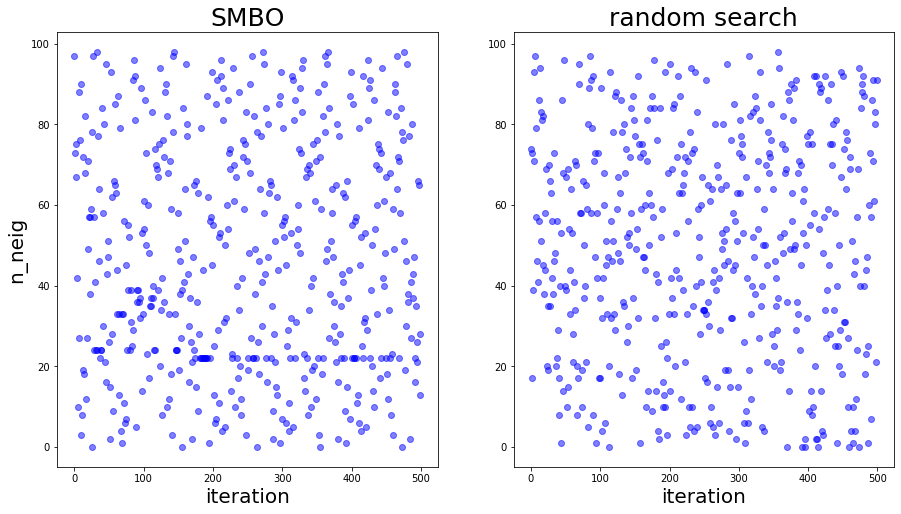

In [221]:
fig,axes = plt.subplots(1,2,figsize=(15,8))
axes[0].plot(results_tpe['iteration'],results_tpe['n_neig'],'bo',alpha = 0.5)
axes[0].set_title('SMBO',size=25)
axes[0].set_xlabel('iteration',size=20)
axes[0].set_ylabel('n_neig',size=20)
axes[1].plot(results_tpe['iteration'],results_rand['n_neig'],'bo',alpha = 0.5)
axes[1].set_title('random search',size=25)
axes[1].set_xlabel('iteration',size=20)
plt.show()

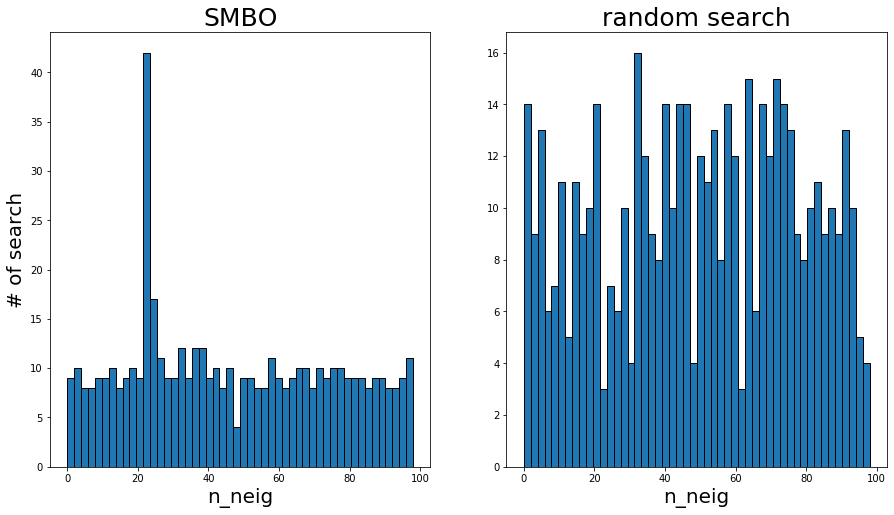

In [220]:
fig,axes = plt.subplots(1,2,figsize=(15,8))
axes[0].hist(results_tpe['n_neig'],bins=50,edgecolor ='k')
axes[0].set_title('SMBO',size=25)
axes[0].set_xlabel('n_neig',size=20)
axes[0].set_ylabel('# of search',size=20)
axes[1].hist(results_rand['n_neig'],bins=50,edgecolor ='k')
axes[1].set_title('random search',size=25)
axes[1].set_xlabel('n_neig',size=20)
plt.show()

In [247]:
knn = KNeighborsClassifier(n_neighbors=22,algorithm='kd_tree',metric='minkowski',leaf_size=23).fit(X_train_scaled,y_train)
y_predict = knn.predict(X_test_scaled)
pd.DataFrame(confusion_matrix(y_test,y_predict),index=['True 0','True 1'],
             columns=['Predicted 0','Predicted 1'])

,Predicted 0,Predicted 1
True 0,111,25
True 1,16,98


In [248]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84       136
           1       0.80      0.86      0.83       114

    accuracy                           0.84       250
   macro avg       0.84      0.84      0.84       250
weighted avg       0.84      0.84      0.84       250



# Conclusion
For the given anonymous dataset, a simple KNN algorithm was quickly applied in an attempt to classify the target variables into 0 or 1. When K=1, the f1-score was ~ 0.76, but based on the "Error rate" figure, it can be seen that the model is overfitting in this case. By chossing **K=23**, the model could not only generalize, but also maximize the classification performance to (f1-score: 0.84) on the test set.